In [149]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
def derivativa_sigmoid(x):
    return x * (1 - x)

class expert():
    
    def __init__(self,ne,nh,ns):
        self.W1=np.random.uniform(size=(ne,nh))
        self.b1=np.random.uniform(size=(1,nh))
        self.W2=np.random.uniform(size=(hiddenlayer_neurons,output_neurons))
        self.b2=np.random.uniform(size=(1,output_neurons))
    
    def train(self, max_epoch, alpha, X, y):
        #m represent o numero de samples
        m = X.shape[0]

        eqm = []
        for epoch in range(1,max_epoch):
            #Forward Propogation
            #hidden
            a1=np.dot(X,self.W1) + self.b1
            z1 = sigmoid(a1)
            #saida
            a2=np.dot(z1,self.W2)+ self.b2
            z2 = sigmoid(a2)

            #Calculo do erro e eqm
            erro_epoca = y-z2
            _eqm =  1.0/len(y) * np.sum(np.sum(np.square(erro_epoca), axis=0))
            eqm.append(_eqm)
            
            #Backpropagation
            delta_output = derivatives_sigmoid(z2)
            delta_hidden = derivatives_sigmoid(z1)
            d_z2 = erro_epoca * delta_output
            erro_hidden = d_z2.dot(self.W2.T)
            d_z1 = erro_hidden * delta_hidden
            
            #Atualiza pesos
            self.W2 += z1.T.dot(d_z2) * alpha
            self.b2 += np.sum(d_z2, axis=0,keepdims=True) * alpha
            self.W1 += X.T.dot(d_z1) * alpha
            self.b1 += np.sum(d_z1, axis=0,keepdims=True) * alpha

                    
        import matplotlib.pyplot as plt
        plt.plot(eqm)
        plt.show()
            

        

In [153]:
#Variable initialization
max_epocas=5000 
alpha=0.1 #Setting learning rate
ne = X.shape[1] #numero de features no dataset
nh = 3 #numero neuronios hidden
ns = 1 #numero neuronios saida

In [154]:
ep =expert(ne,nh,ns)

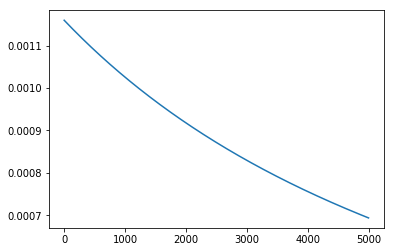

In [157]:
ep.train(max_epocas, learning_rate, X, y)